In [1]:
import pandas as pd
import numpy as np

#import datetime
from datetime import datetime, date, timedelta
import time

from yahooquery import Ticker

import requests
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xlwings as xw




In [2]:

wb = xw.Book("daily.xlsm")
sht2 = wb.sheets['options_chain']
sht3 = wb.sheets['ticker_list']
sht1 = wb.sheets['correl']

In [3]:
shtlist= sht3.range('A1').options(pd.DataFrame, 
                             header=False,
                             index=False, 
                             expand='table').value

In [4]:
stonks=shtlist.iloc[1:,0].tolist()

In [5]:
stonks

['AAPL',
 'MSFT',
 'AMZN',
 'TSLA',
 'GOOG',
 'GOOGL',
 'META',
 'NVDA',
 'PEP',
 'COST',
 'CSCO',
 'CMCSA',
 'ADBE',
 'INTC',
 'TMUS',
 'TXN',
 'QCOM',
 'AMD',
 'AMGN',
 'HON',
 'INTU',
 'AMAT',
 'ADP',
 'QQQ',
 'KO',
 'SBUX',
 'WMT',
 'JNJ',
 'PG',
 'UVXY',
 'SCHB',
 'HD',
 'SCHD']

In [6]:

stonks2 = Ticker(stonks, asynchronous=True)

In [7]:
# 90 days worth of data
d = datetime.today() - timedelta(days=120)
yq_data = stonks2.history(start=d, interval='1d')

In [8]:
yq_data.reset_index(inplace=True)
yq_data

,symbol,date,open,volume,low,high,close,adjclose,dividends
0,AAPL,2022-11-18,152.309998,74829600,149.970001,152.699997,151.289993,151.059357,0.0
1,AAPL,2022-11-21,150.160004,58724100,147.720001,150.369995,148.009995,147.784348,0.0
2,AAPL,2022-11-22,148.130005,51804100,146.929993,150.419998,150.179993,149.951035,0.0
3,AAPL,2022-11-23,149.449997,58301400,149.339996,151.830002,151.070007,150.839706,0.0
4,AAPL,2022-11-25,148.309998,35195900,147.119995,148.880005,148.110001,147.884201,0.0
...,...,...,...,...,...,...,...,...,...
2668,SCHD,2023-03-13,70.790001,10916900,70.540001,72.010002,70.930000,70.930000,0.0
2669,SCHD,2023-03-14,72.169998,4028600,70.720001,72.180000,71.559998,71.559998,0.0
2670,SCHD,2023-03-15,70.550003,6360100,70.040001,70.970001,70.970001,70.970001,0.0
2671,SCHD,2023-03-16,70.470001,4241700,70.010002,71.739998,71.650002,71.650002,0.0


In [9]:
#get latest volume
today_volume = yq_data.groupby('symbol')['volume'].last().to_dict()

In [10]:
# drop columns that are not used
yq_data = yq_data.drop(columns = ['open', 'low', 'close', 'high'])# 'dividends'])

In [11]:
# calculate log return using daily historical price data
yq_data = yq_data.assign(logret=np.log(yq_data.adjclose).groupby(yq_data.symbol).diff()) 

In [12]:
yq_data2 = yq_data[["date", "symbol","logret"]]

In [13]:
yq_data2

,date,symbol,logret
0,2022-11-18,AAPL,NaN
1,2022-11-21,AAPL,-0.021919
2,2022-11-22,AAPL,0.014555
3,2022-11-23,AAPL,0.005909
4,2022-11-25,AAPL,-0.019788
...,...,...,...
2668,2023-03-13,SCHD,-0.014417
2669,2023-03-14,SCHD,0.008843
2670,2023-03-15,SCHD,-0.008279
2671,2023-03-16,SCHD,0.009536


In [14]:
yq_data2.set_index('date')

,symbol,logret
date,,
2022-11-18,AAPL,NaN
2022-11-21,AAPL,-0.021919
2022-11-22,AAPL,0.014555
2022-11-23,AAPL,0.005909
2022-11-25,AAPL,-0.019788
...,...,...
2023-03-13,SCHD,-0.014417
2023-03-14,SCHD,0.008843
2023-03-15,SCHD,-0.008279


In [15]:
yq_dataT=yq_data2.pivot_table(index = ["date"], 
              columns = "symbol" , 
              values = "logret", 
              aggfunc = "sum",
              fill_value = "").reset_index()

In [16]:
yq_dataT.head()

symbol,date,AAPL,ADBE,ADP,AMAT,AMD,AMGN,AMZN,CMCSA,COST,...,QCOM,QQQ,SBUX,SCHB,SCHD,TMUS,TSLA,TXN,UVXY,WMT
0,2022-11-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-11-21,-0.021919,-0.028729,0.006152,0.004194,-0.015203,0.003024,-0.018007,-0.004357,-0.000573,...,-0.029914,-0.010340,0.003770,-0.004961,0.002726,0.007030,-0.070822,-0.015997,-0.040917,0.006105
2,2022-11-22,0.014555,0.028789,0.016822,0.017910,0.037781,-0.003860,0.007972,0.021599,0.016261,...,0.028298,0.014300,0.001118,0.013316,0.014668,0.011411,0.012079,0.027575,-0.053935,0.003566
3,2022-11-23,0.005909,0.014700,0.002326,0.008300,0.015167,-0.012797,0.009929,0.012176,0.004764,...,0.012058,0.009987,0.011013,0.006168,-0.000383,-0.009811,0.075310,0.009882,-0.033294,0.004801
4,2022-11-25,-0.019788,-0.004417,0.005204,-0.017331,-0.016630,0.001199,-0.007678,0.003372,-0.001554,...,-0.013677,-0.006600,0.000402,0.001060,0.002297,0.006176,-0.001858,-0.010729,0.007782,0.004256


In [17]:
# variance - covariance Matrix
cov_matrix = yq_dataT.cov()
cov_matrix

symbol,AAPL,ADBE,ADP,AMAT,AMD,AMGN,AMZN,CMCSA,COST,CSCO,...,QCOM,QQQ,SBUX,SCHB,SCHD,TMUS,TSLA,TXN,UVXY,WMT
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000322,0.000256,0.000159,0.000304,0.000353,0.000060,0.000258,0.000152,0.000156,0.000136,...,0.000310,0.000236,0.000108,0.000170,0.000112,0.000052,0.000425,0.000215,-0.000482,0.000055
ADBE,0.000256,0.000492,0.000165,0.000367,0.000512,0.000021,0.000365,0.000198,0.000162,0.000146,...,0.000352,0.000272,0.000155,0.000195,0.000122,0.000038,0.000386,0.000233,-0.000658,0.000047
ADP,0.000159,0.000165,0.000218,0.000223,0.000226,0.000064,0.000186,0.000121,0.000109,0.000114,...,0.000202,0.000148,0.000113,0.000123,0.000104,0.000054,0.000072,0.000169,-0.000378,0.000070
AMAT,0.000304,0.000367,0.000223,0.000644,0.000656,0.000076,0.000419,0.000228,0.000252,0.000161,...,0.000476,0.000323,0.000169,0.000230,0.000155,0.000078,0.000505,0.000343,-0.000782,0.000085
AMD,0.000353,0.000512,0.000226,0.000656,0.001022,0.000020,0.000491,0.000253,0.000258,0.000168,...,0.000573,0.000394,0.000155,0.000272,0.000168,0.000068,0.000674,0.000369,-0.000875,0.000101
AMGN,0.000060,0.000021,0.000064,0.000076,0.000020,0.000126,0.000062,0.000049,0.000055,0.000030,...,0.000064,0.000050,0.000062,0.000042,0.000044,0.000047,0.000031,0.000071,-0.000102,0.000041
AMZN,0.000258,0.000365,0.000186,0.000419,0.000491,0.000062,0.000588,0.000234,0.000209,0.000166,...,0.000310,0.000307,0.000179,0.000212,0.000134,0.000041,0.000416,0.000243,-0.000578,0.000091
CMCSA,0.000152,0.000198,0.000121,0.000228,0.000253,0.000049,0.000234,0.000242,0.000132,0.000119,...,0.000217,0.000160,0.000124,0.000125,0.000098,0.000045,0.000109,0.000154,-0.000308,0.000058
COST,0.000156,0.000162,0.000109,0.000252,0.000258,0.000055,0.000209,0.000132,0.000259,0.000094,...,0.000215,0.000151,0.000088,0.000113,0.000088,0.000061,0.000199,0.000174,-0.000293,0.000073


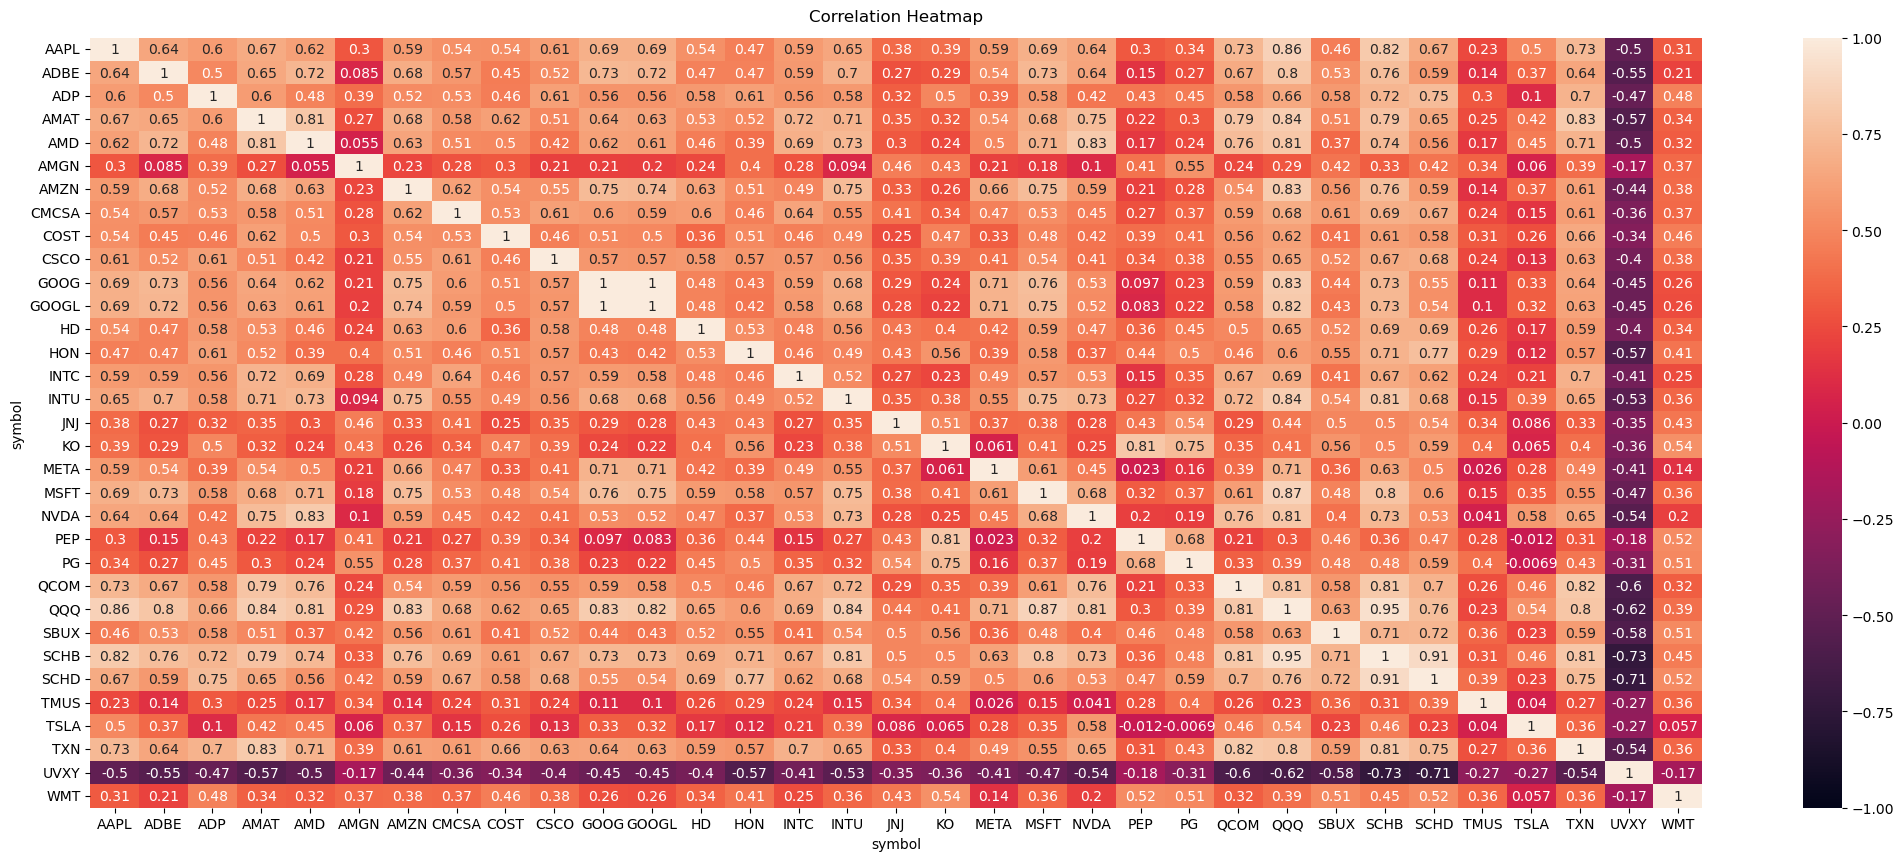

In [18]:
#correlation matricx

plt.figure(figsize=(26, 10))
heatmap1 = sns.heatmap(yq_dataT.corr(), vmin=-1, vmax=1, annot=True)

heatmap1.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

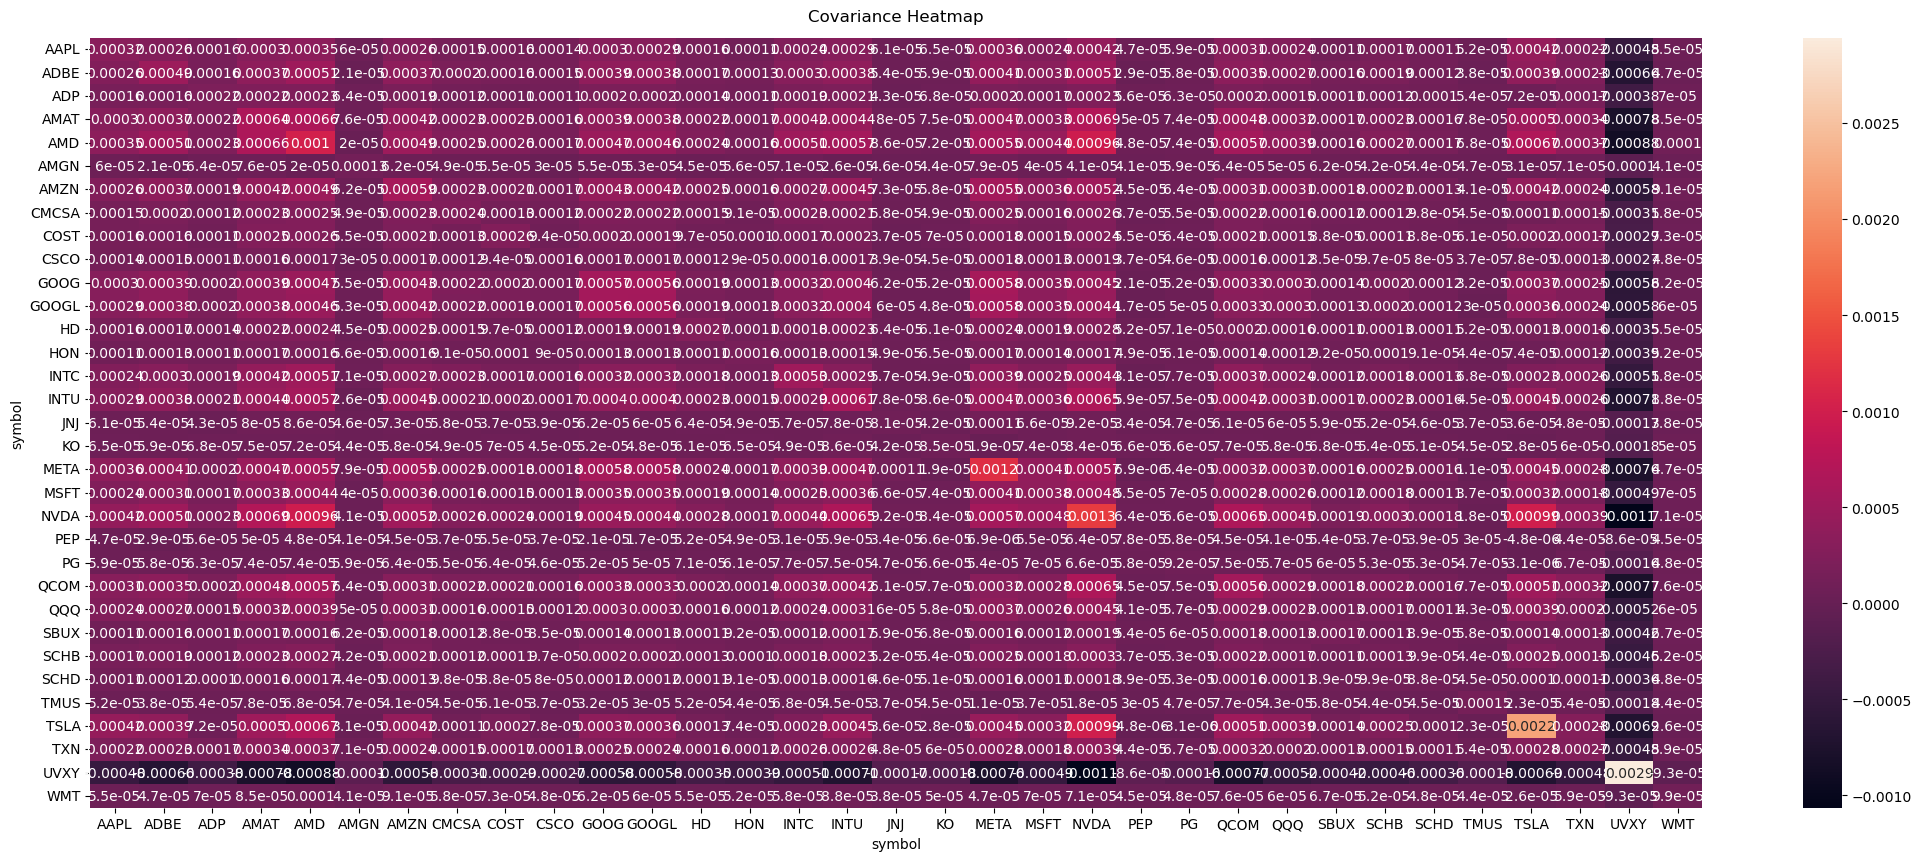

In [19]:
plt.figure(figsize=(26, 10))
heatmap2 = sns.heatmap(cov_matrix, annot=True)

heatmap2.set_title('Covariance Heatmap', fontdict={'fontsize':12}, pad=12);

In [20]:
avg_rets = yq_dataT.mean()
avg_rets

C:\Users\gavar\AppData\Local\Temp\ipykernel_10204\4283985377.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_rets = yq_dataT.mean()


symbol
AAPL     0.000318
ADBE     0.000978
ADP     -0.002129
AMAT     0.002007
AMD      0.003520
AMGN    -0.002649
AMZN     0.000615
CMCSA    0.000631
COST    -0.000874
CSCO     0.000703
GOOG     0.000575
GOOGL    0.000520
HD      -0.000855
HON     -0.001787
INTC     0.000125
INTU     0.001071
JNJ     -0.001625
KO      -0.000047
META     0.006879
MSFT     0.001846
NVDA     0.006333
PEP     -0.000270
PG       0.000108
QCOM    -0.000161
QQQ      0.000889
SBUX     0.000156
SCHB    -0.000141
SCHD    -0.000964
TMUS    -0.000541
TSLA    -0.000004
TXN      0.000125
UVXY    -0.003794
WMT     -0.000827
dtype: float64

Text(0.5, 1.0, 'Stock Daily returns')

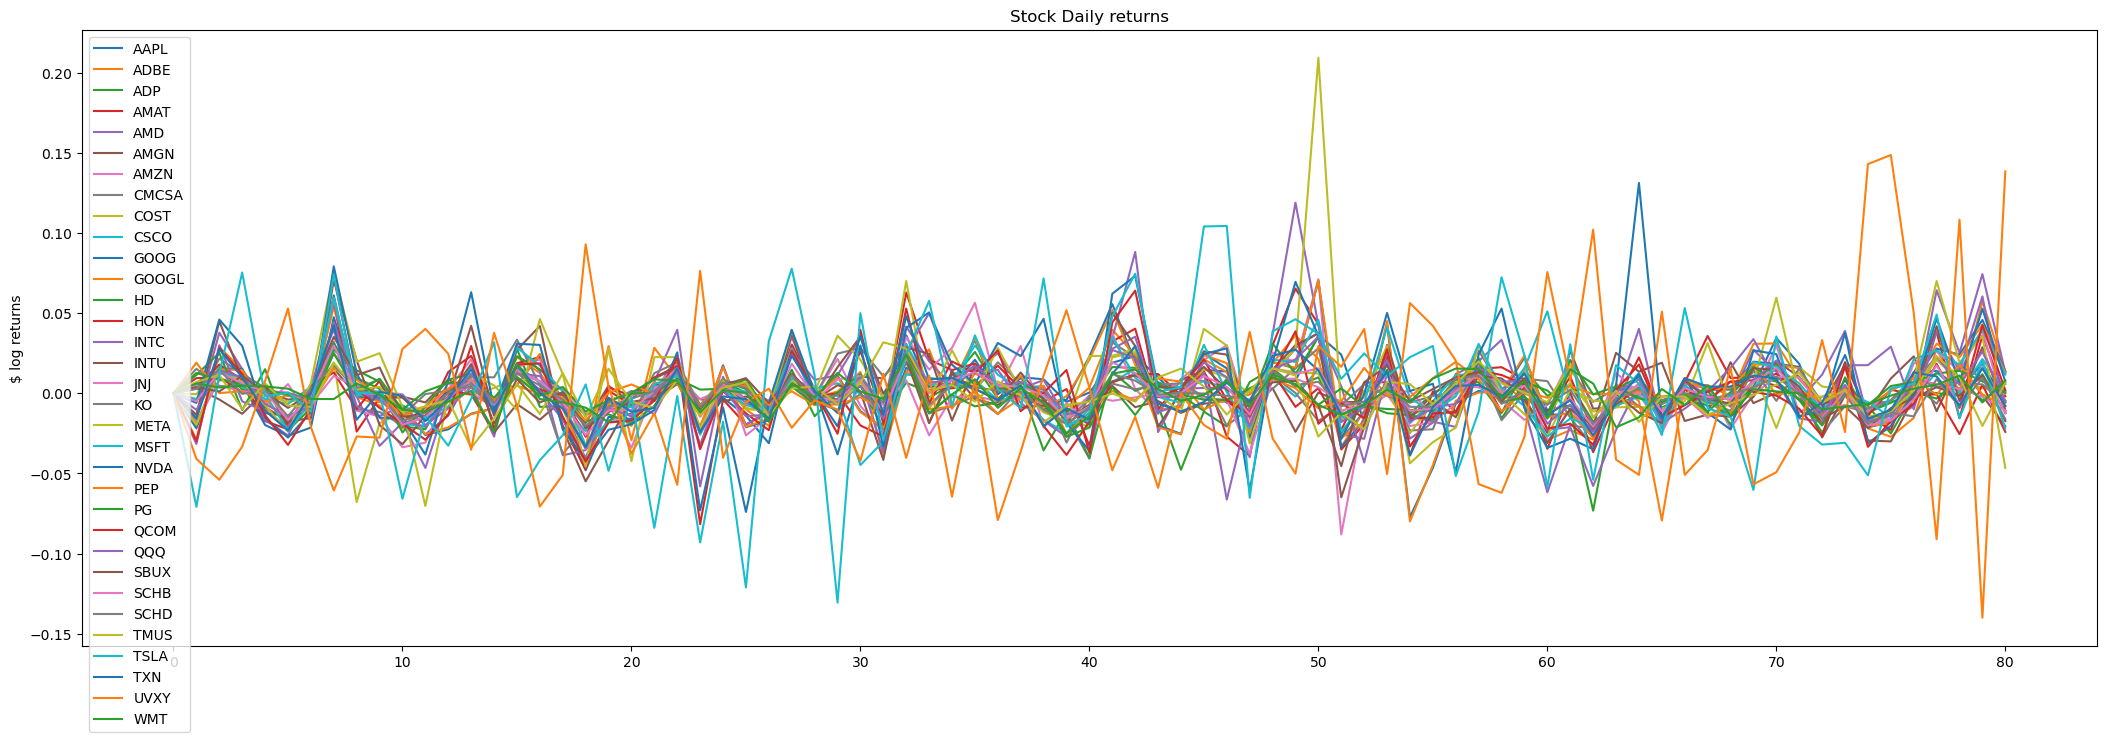

In [21]:
# Plot returns
yq_dataT.plot(figsize=(26,8))
plt.legend(loc='upper left')
plt.ylabel("$ log returns")
plt.title("Stock Daily returns")


In [22]:
sht1["A1"].options(pd.DataFrame, index=False, header=1,expand='table').value = yq_dataT.corr().reset_index()

In [ ]:
#fig = plt.figure()
#plt.plot([1, 2, 3])

In [ ]:
#sht1.pictures.add(fig, name='MyPlot', update=True)